In [1]:
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_context('paper')
sns.set_style('white')

# Hands-on Activity 23.3: Probability of Improvement

## Objectives

+ Develop intuition about the probability of improvement

## Probability of Improvement
Let's reintroduce the same running example as the previous hands-on activity.

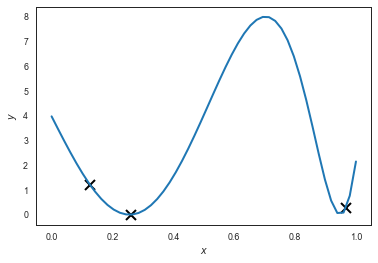

In [2]:
def f(x):
    return 4 * (1. - np.sin(6 * x + 8 * np.exp(6 * x - 7.))) 

np.random.seed(123456) # For reproducibility
n_init = 3
X = np.random.rand(n_init) # In 1D you don't have to use LHS
Y = f(X)
plt.plot(X, Y, 'kx', markersize=10, markeredgewidth=2)
x = np.linspace(0, 1)
plt.plot(x, f(x), linewidth=2)
plt.xlabel('$x$')
plt.ylabel('$y$');

Just like in the previous hands-on activity, assume that we have made some observations and that we have used them to do Gaussian process regression resulting in the point-predictive distribution:
$$
p(y|\mathbf{x},\mathcal{D}_{n}) = \mathcal{N}\left(y|m_{n}(\mathbf{x}), \sigma^2_{n}(\mathbf{x})\right),
$$
where $m_{n}(\mathbf{x})$ and $\sigma^2_{n}(\mathbf{x})$ are the predictive mean and variance respectively.
Here is the code for this:

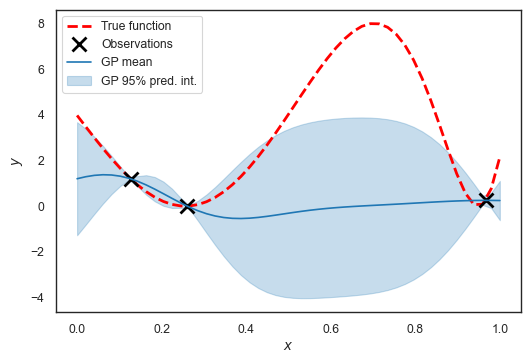

In [3]:
import GPy
# The kernel we use
k = GPy.kern.RBF(1, lengthscale=0.15, variance=4.)
gpr = GPy.models.GPRegression(X[:, None], Y[:, None], k)
# Assuming that we know there is no measurement noise:
gpr.likelihood.variance.constrain_fixed(1e-16)
# You can evaluate the predictive distribution anywhere:
m, sigma2 = gpr.predict(x[:, None])
# And you can visualize the results as follows
# Standard deviation
sigma = np.sqrt(sigma2)
# Lower quantile
l = m - 1.96 * sigma
u = m + 1.96 * sigma
fig, ax = plt.subplots(dpi=100)
plt.plot(x, f(x), 'r--', linewidth=2, label='True function')
ax.plot(X, Y, 'kx', markersize=10, markeredgewidth=2, label='Observations')
ax.plot(x, m, label='GP mean')
ax.fill_between(x, l.flatten(), u.flatten(), color=sns.color_palette()[0], alpha=0.25,
                label='GP 95% pred. int.')
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
plt.legend(loc='best');

What if you try to find the point that maximizes the probability of getting an observation greater than the ones you have so far?
Let's derive this.
First, let's call $y_n^*$ the current maximum in your dataset, i.e.,
$$
y_n^* = \max_{1\le i\le n}y_i.
$$
We define the following acquisition function:
$$
a_n(\mathbf{x}) = \mathbb{P}[y > y_n^* + \psi | \mathbf{x}, \mathcal{D}_n].
$$
We read "$a_n(\mathbf{x})$" is the probability that we observe at $x$ a $y$ that is greater than the currently observed maximum $y_n^*$ by at least $\psi>0$.
The good thing is that it is possible to get an analytical answer because our point predictive distribution is Gaussian.
In particular, we get:
$$
\begin{align}
a_n(\mathbf{x}) &=& \mathbb{P}[y > y_n^* + \psi | x, \mathcal{D}_n]\\
&=& \mathbb{P}\left[\frac{y - \mu_n(\mathbf{x})}{\sigma_n(\mathbf{x})} > \frac{y_n^* + \psi - \mu_n(\mathbf{x})}{\sigma_n(\mathbf{x})} \Big| \mathbf{x}, \mathcal{D}_n\right]\\
&=& 1 - \mathbb{P}\left[\frac{y - \mu_n(\mathbf{x})}{\sigma_n(\mathbf{x})} \le \frac{y_n^* + \psi - \mu_n(\mathbf{x})}{\sigma_n(\mathbf{x})} \Big| \mathbf{x}, \mathcal{D}_n\right]\\
&=& 1 - \Phi\left(\frac{y_n^* + \psi - \mu_n(\mathbf{x})}{\sigma_n(\mathbf{x})} \right)\\
&=& \Phi\left(\frac{\mu_n(\mathbf{x}) - y_n^* - \psi}{\sigma_n(\mathbf{x})} \right),
\end{align}
$$
where we used that since $y_n | \mathbf{x}_n, \mathcal{D}_n$ is Gaussian with mean $\mu_n(\mathbf{x})$ and variance $\sigma_n^2(\mathbf{x})$, then $\frac{y_n-\mu_n(\mathbf{x})}{\sigma_n(\mathbf{x})}$ is a standard normal, and we also used that the CDF of the standard normal satisfies this property:
$$
\Phi(-z) = 1 - \Phi(z).
$$

Here is the code for this activation function:

In [4]:
def poi(m, sigma, ymax, psi=0.):
    """
    Return the probability of improvement.
    
    Arguments:
    m        -      the predictive mean at the test points.
    sigma        -  the predictive standard deviation at the test points.
    ymax     -      the maximum observed value (so far).
    psi      -      a parameter that controls exploration.
    """
    return st.norm.cdf((m - ymax - psi) / sigma)

Let's visualize this:

In [5]:
def plot_poi(psi=0.):
    fig, ax = plt.subplots(dpi=100)
    ax.set_title('$\psi={0:1.2f}$'.format(psi))
    ax.plot(X, Y, 'kx', markersize=10, markeredgewidth=2)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.plot(x, m)
    ax.fill_between(x, l.flatten(), u.flatten(), color=sns.color_palette()[0], alpha=0.25)
    af_values = poi(m, sigma, Y.max(), psi)
    next_id = np.argmax(af_values)
    next_x = x[next_id]
    af_max = af_values[next_id]
    ax2 = ax.twinx()
    ax2.plot(x, af_values, color=sns.color_palette()[1])
    ax2.set_ylabel('Probability of Improvement', color=sns.color_palette()[1])
    plt.setp(ax2.get_yticklabels(), color=sns.color_palette()[1])
    ax2.plot(next_x * np.ones(100), np.linspace(0, af_max, 100), color=sns.color_palette()[1],
         linewidth=1)
    ax2.set_ylim(0, 1)

from ipywidgets import interactive, interact_manual
    
interactive(plot_poi, psi=(0., 4., 0.001))

interactive(children=(FloatSlider(value=0.0, description='psi', max=4.0, step=0.001), Output()), _dom_classes=…

### Questions
+ Experiment with different values of $\psi$.
+ When do you get exploration?
+ When do you get exploitation?

## Bayesian global optimization with the probability of improvement

Let's now run the Bayesian global optimization algorithm using the probability of improvement as the information acquisition function.
Here is the generic code from the previous hands-on activity:

In [6]:
def maximize(f, gpr, X_design, alpha, psi=0., max_it=6):
    """
    Optimize f using a limited number of evaluations.
    
    :param f:        The function to optimize.
    :param gpr:      A Gaussian process model to use for representing our state of knowldege.
    :param X_design: The set of candidate points for identifying the maximum.
    :param alpha:    The acquisition function.
    :param psi:      The parameter value for the acquisition function (not used for EI).
    :param max_it:   The maximum number of iterations.
    """
    af_all = []
    for count in range(max_it):
        m, sigma2 = gpr.predict(X_design)
        sigma = np.sqrt(sigma2)
        l = m - 1.96 * sigma
        u = m + 1.96 * sigma
        af_values = alpha(m, sigma, gpr.Y.max(), psi=psi)
        i = np.argmax(af_values)
        X = np.vstack([gpr.X, X_design[i:(i+1), :]])
        y = np.vstack([gpr.Y, [f(X_design[i, :])]])
        gpr.set_XY(X, y)
        # Uncomment the following to optimize the hyper-parameters
        # gpr.optimize()
        af_all.append(af_values[i])
        fig, ax = plt.subplots(dpi=100)
        ax.plot(gpr.X, gpr.Y, 'kx', markersize=10, markeredgewidth=2)
        ax.set_xlabel('$x$')
        ax.set_ylabel('$y$')
        ax.plot(x, m)
        ax.fill_between(X_design.flatten(), l.flatten(), u.flatten(), color=sns.color_palette()[0], alpha=0.25)
        ax2 = ax.twinx()
        ax2.plot(X_design, af_values, color=sns.color_palette()[1])
        plt.setp(ax2.get_yticklabels(), color=sns.color_palette()[1])
        ax2.set_ylabel('acquisition function', color=sns.color_palette()[1])
        ax2.plot(X_design[i, :] * np.ones(100), np.linspace(0, af_values[i], 100), color=sns.color_palette()[1],
                 linewidth=1)
    return af_all

And here is how we can use the code with the probability of improvement:

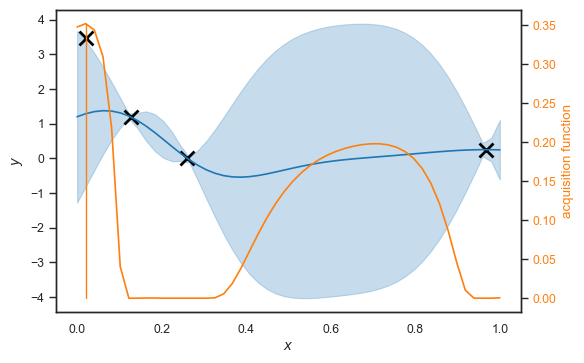

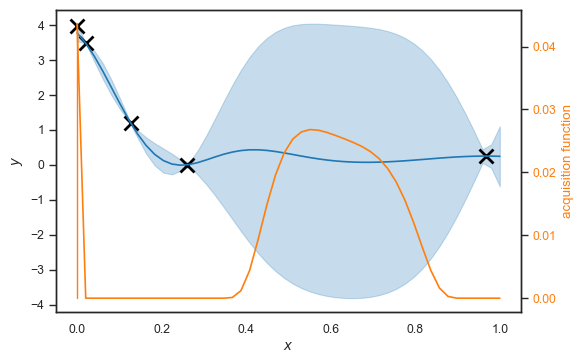

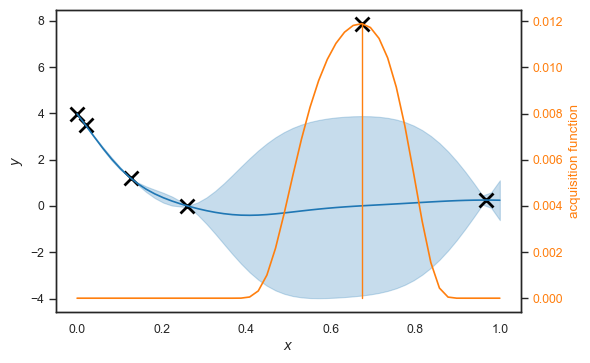

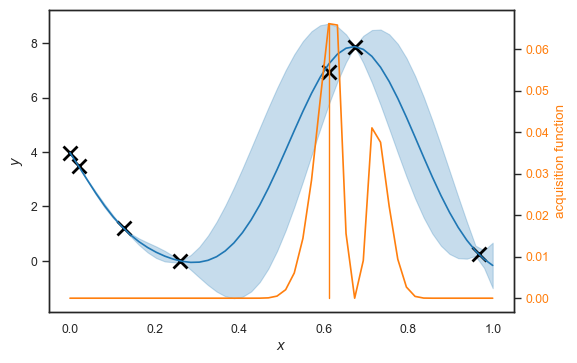

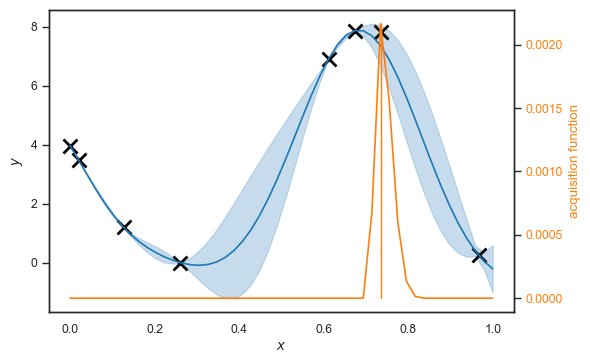

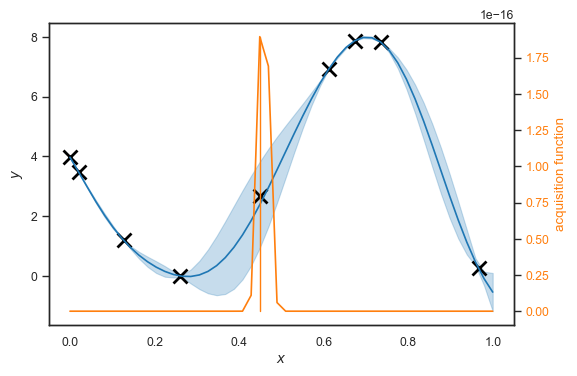

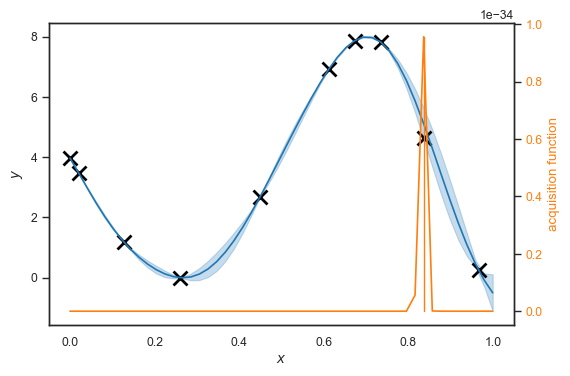

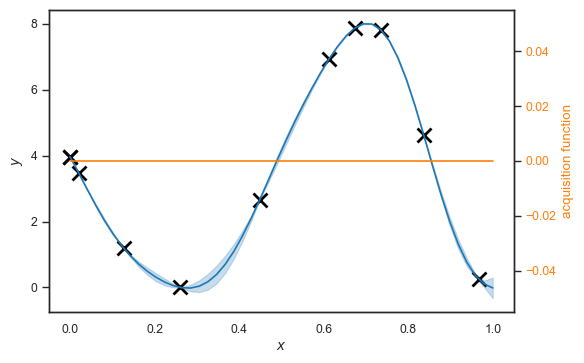

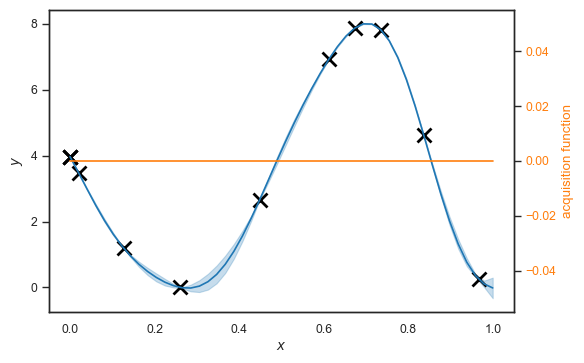

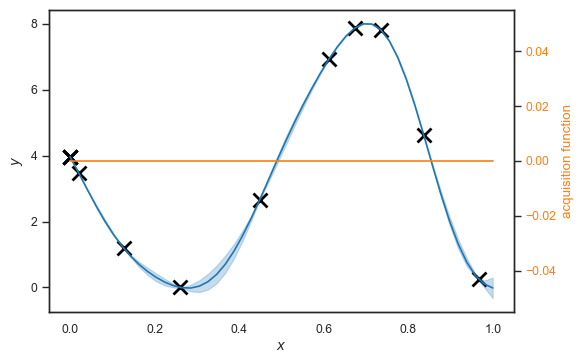

In [8]:
# Prepare the initial statistical model
k = GPy.kern.RBF(1, lengthscale=0.15, variance=4.)
gpr = GPy.models.GPRegression(X[:, None], Y[:, None], k)
gpr.likelihood.variance.constrain_fixed(1e-16)

# Run the algorithm
af_all = maximize(f, gpr, x[:, None], alpha=poi, psi=0.5, max_it=10)

### Questions

+ Repeat the main algorithm using POI for a $\psi$ that exploits. Does the method converge?
+ Repeat the main algorithm using POI for a $\psi$ that explores. Does the method converge?